# Benchmark DTNN model on the QM7 dataset

In [1]:
import sys
sys.path.append('../../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


from molgraph.chemistry.benchmark import configs
from molgraph.chemistry.benchmark import tf_records
from molgraph.chemistry import datasets

### Define molecular graph encoder

In [2]:
from molgraph.chemistry import features
from molgraph.chemistry import AtomFeaturizer, BondFeaturizer
from molgraph.chemistry import MolecularGraphEncoder3D

atom_encoder = AtomFeaturizer([
    features.Symbol(),
    features.Hybridization(),
    features.FormalCharge(),
    features.TotalNumHs(),
    features.TotalValence(),
    features.NumRadicalElectrons(),
    features.Degree(),
    features.ChiralCenter(),
    features.Aromatic(),
    features.Ring(),
    features.Hetero(),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.CIPCode(),
    features.ChiralCenter(),
    features.RingSize(),
    features.Ring(),
    features.CrippenLogPContribution(),
    features.CrippenMolarRefractivityContribution(),
    features.TPSAContribution(),
    features.LabuteASAContribution(),
    features.GasteigerCharge(),
])

encoder = MolecularGraphEncoder3D(
    atom_encoder,
    conformer_generator=None,
    edge_radius=None, # max radius
    coloumb=True,
)

### Obtain dataset and molecular graph

In [3]:
qm7 = datasets.get('qm7')

x_train = encoder(qm7['train']['x'])
y_train = qm7['train']['y']

x_val = encoder(qm7['validation']['x'])
y_val = qm7['validation']['y']

x_test = encoder(qm7['test']['x'])
y_test = qm7['test']['y']

type_spec = x_train.merge().unspecific_spec

### `tf.data.Dataset` API

In [4]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .map(lambda x, *args: (x.merge(), *args), -1)
    .prefetch(-1)
)

### `tf.keras.Sequential` API

In [5]:
from molgraph.layers import DTNNConv
from molgraph.layers import LaplacianPositionalEncoding
from molgraph.layers import Readout
from molgraph.layers import NodeMinMaxScaling, EdgeMinMaxScaling

node_preprocessing = NodeMinMaxScaling(
    feature_range=(0, 1), threshold=True)
edge_preprocessing = EdgeMinMaxScaling(
    feature_range=(0, 1), threshold=True)

node_preprocessing.adapt(train_ds.map(lambda x, *args: x))
edge_preprocessing.adapt(train_ds.map(lambda x, *args: x))

model = tf.keras.Sequential([
    keras.layers.Input(type_spec=type_spec),
    node_preprocessing,
    edge_preprocessing,
    DTNNConv(),
    DTNNConv(),
    DTNNConv(),
    Readout(),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(1024, 'relu'),
    keras.layers.Dense(y_train.shape[-1])
])


optimizer = keras.optimizers.Adam(1e-4)
loss = keras.losses.MeanAbsoluteError(name='mae')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-6,
        mode='min',
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='min',
        restore_best_weights=True,
    )
]

model.compile(optimizer, loss)
history = model.fit(
    train_ds, callbacks=callbacks, validation_data=val_ds, epochs=100
)
model.evaluate(test_ds)

Epoch 1/100
180/180 [==============================] - 8s 34ms/step - loss: 1236.8972 - val_loss: 923.6510 - lr: 1.0000e-04
Epoch 2/100
180/180 [==============================] - 6s 32ms/step - loss: 563.0248 - val_loss: 313.3411 - lr: 1.0000e-04
Epoch 3/100
180/180 [==============================] - 6s 31ms/step - loss: 164.7467 - val_loss: 231.8161 - lr: 1.0000e-04
Epoch 4/100
180/180 [==============================] - 6s 32ms/step - loss: 124.8009 - val_loss: 94.6347 - lr: 1.0000e-04
Epoch 5/100
180/180 [==============================] - 6s 33ms/step - loss: 110.4212 - val_loss: 109.4044 - lr: 1.0000e-04
Epoch 6/100
180/180 [==============================] - 6s 36ms/step - loss: 112.1590 - val_loss: 118.0195 - lr: 1.0000e-04
Epoch 7/100
180/180 [==============================] - 6s 33ms/step - loss: 107.2536 - val_loss: 94.9400 - lr: 1.0000e-04
Epoch 8/100
180/180 [==============================] - 6s 32ms/step - loss: 98.7392 - val_loss: 60.7436 - lr: 1.0000e-04
Epoch 9/100
180/180

20.330110549926758

(0.0, 200.0)

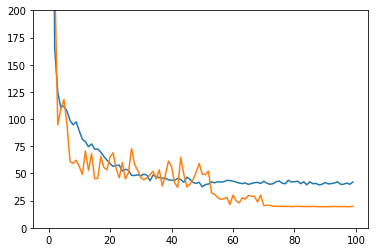

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 200);